In [1]:
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
from darts.metrics import mape
from darts.metrics import mase
import numpy as np
import datetime as dt
# import os
# os.environ['KMP_DUPLICATE_LTB_OK'] = 'True'

In [2]:
# Read a pandas DataFrame
df = pd.read_csv('../../data/prepared/df_energy_climate_2020.csv')

In [3]:
series_price = TimeSeries.from_dataframe(df, 
                                   time_col="datetime",
                                   value_cols=["energy_price"])
series_wind = TimeSeries.from_dataframe(df, 
                                   time_col="datetime",
                                   value_cols=["wind_speed"])

In [4]:
splitting_point = (int(len(series_price)*0.18))

# Set aside the second half of series as a validation series
train_price, val_price = series_price[:-splitting_point], series_price[-splitting_point:]

train_wind, val_wind = series_wind[:-splitting_point], series_wind[-splitting_point:]

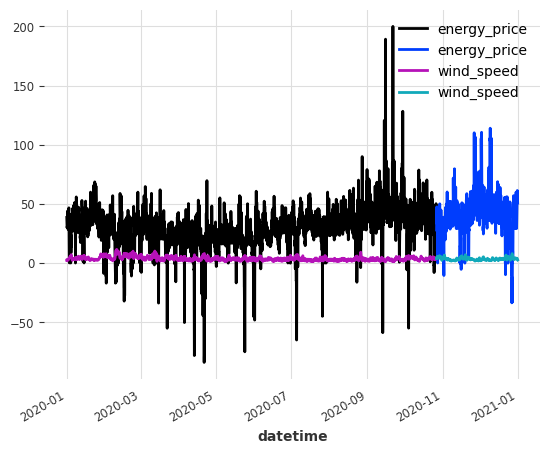

In [5]:
train_price.plot()
val_price.plot()
train_wind.plot()
val_wind.plot()


In [6]:
from darts.dataprocessing.transformers import Scaler

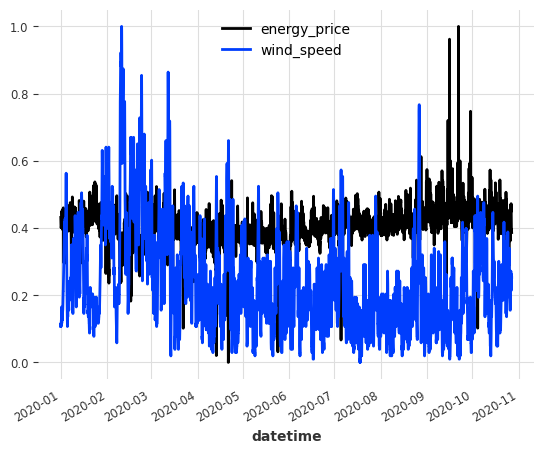

In [7]:
scaler = Scaler()
train_price_scaled, train_wind_scaled = scaler.fit_transform([train_price, train_wind])


train_price_scaled.plot()
train_wind_scaled.plot()

In [8]:
from darts.models import NBEATSModel

In [9]:
model_nbeats = NBEATSModel(input_chunk_length=168, output_chunk_length=24, random_state=42)

model_nbeats.fit([train_price_scaled, train_wind_scaled], epochs=50, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


: 

: 

In [ ]:
pred_price = model_nbeats.predict(series=train_price_scaled, n=36)
pred_wind = model_nbeats.predict(series=train_wind_scaled, n=36)

# scale back:
pred_price, pred_wind = scaler.inverse_transform([pred_price, pred_wind])

plt.figure(figsize=(10, 6))
series_price.plot(label='actual (price)')
series_wind.plot(label='actual (wind)')
pred_price.plot(label='forecast (price)')
pred_wind.plot(label='forecast (wind)')


## RNN model (Recurrent neural network)
class of artificial neural networks where connections between nodes can create a cycle, allowing output from some nodes to affect subsequent input to the same nodes. Mostly used in the fields of natural language processing and speech recognition.


In [ ]:
from darts.models import RNNModel

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df[df['datetime'] <= dt.datetime(2020,10,26)]

series = TimeSeries.from_dataframe(df, 'datetime', 'energy_price')

In [ ]:
cov_df = pd.read_csv('../../data/prepared/df_energy_climate_2020.csv')
cov_df['datetime'] = pd.to_datetime(cov_df['datetime'])
cov_df = cov_df[cov_df['datetime'] >= dt.datetime(2020,10,27)]

cov_series = TimeSeries.from_dataframe(cov_df, 'datetime', 'wind_speed')

In [ ]:
train, val = series.split_after(pd.Timestamp('2020-08-31'))

scaler = Scaler()
ts_tr = scaler.fit_transform(series)

train_tr = scaler.transform(train)
val_tr = scaler.transform(val)

In [ ]:
model = RNNModel(
    input_chunk_length=24, 
    output_chunk_length=24,
    n_epochs=200, # training numbers
    random_state=64,    # fix random number
    )

In [ ]:
model.fit(train_tr)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | V             | Linear           | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [ ]:
predict = model.predict(n=len(val_tr))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [ ]:
# scaler_cov = Scaler()
# cov_series_tr = scaler_cov.fit_transform(cov_series)
# model_cov = RNNModel(
#     input_chunk_length=24, 
#     output_chunk_length=24,
#     n_epochs=200, # training numbers
#     random_state=64,    # fix random number
# )

# model_cov.fit(
#     train_tr,
#     future_covariates=cov_series_tr
# )

# predict_cov = model_cov.predict(
#     n=len(val_tr),
#     future_covariates=cov_series_tr
# )